##SchNet Architecture

**Tutorial en espanol basado en el libro "deep learning for molecules & materials" de Andrew D. White ([White, 2021](https://doi.org/10.33011/livecoms.3.1.1499).)**

Habitualmente en aprendizaje de maquinas aplicado a quimica computacional una de las mayores dificultades es la definicion de los descriptores (o atributos) que definen a un sistema termodinamico dado, en base a esto una de las maneras de describir es considerar una red neuronal que tenga como entrada la ubicacion espacial $r$ de los atomos y una caracteristica intrinseca de ellos $Z_i$(como podria ser el elemento atomico), y de ahi poder crear una arquitectura que pueda generalizar y obtener un parametro objetivo como lo es la fuerza en los atomos o la energia completa de la configuracion

Las operaciones dentro de la red pueden ser equivariantes o invariantes, donde:

*   Operacion equivariante: Se refiere a la propiedad de la red de transformar las características de los nodos de manera coherente con la estructura del grafo. Esto significa que una permutacion sobre los nodos del grafo genera una diferencia en la salida de la funcion de forma coherente a la permutacion de estos

*   Operacion invariante: Se refiere a la propiedad de la red de producir salidas que son invariantes (no cambian) bajo permutaciones de los nodos del grafo. Esto significa que la salida de la red no depende del orden de los nodos en el grafo. Un ejemplo de esto es promediar todos los valores de los nodos.

A continuacion se va a mostrar un ejemplo de red GNN del tipo SchNet ([K. T. Schütt, 2018](https://doi.org/10.1063/1.5019779)). Se define las coordenadas espaciales del atomo $i$ como

$$r_i = (x_i,y_i,z_i)$$

Para extraer las features (descriptores) a nivel nodo, se realiza una capa de embedding sobre alguna caracteristica relevante de los nodos. En este caso se transforma el numero atomico $Z_i$ a $k$ canales por cada atomo $i$

$$e_{ik} = E(Z_i)$$

Para extraer features a nivel de edge (conexion o enlace) entre atomos, se calcula la distancia euclidiana entre atomos separados

$$ d_{ij} = \left \| r_i - r_j \right \| $$

El concepto de distancia se puede generalizar para obtener mas edge features entre atomos, en base a esto es atractivo aumentar la dimension a $k$ edge features por cada conexion entre un atomo $i,j$. En este caso se trabaja sobre un $\mu_k$ el cual es un vector de distancias que sirve para este proposito, y ademas se agrega $\gamma$ como un hiperparametro al calculo. Esto luego se traduce en un rbf (Radial basis function) como la siguiente

$$ D_{ijk} = \exp\left(-\gamma \left( d_{ij} - \mu_k\right)^2\right) $$

Con esta funcion distancia se puede extraer para el tensor de node features $e_{ik}$ las features correspondientes a los $n$ atomos mas cercanos al atomo $i$, esto hace que se expanda por medio de una funcion $W$ en una componente el tensor de node features donde $i$ es el atomo, $j$ son los N atomos vecinos y $k$ son los canales resultado de la capa de embedding

$$f_{ijk} = W( e_{ik}, D_{ijk}) $$

Con esto se tienen construidas los edge features y los nodes features pero faltan agregar capas densas para generalizar la red, se definen asi las capas $h_1(), h_2(), h_3()$, las cuales se aplican en una etapa $t$ de la red como sigue

$$e_{ik}^{t+1} = e_{ik}^t + \sum_{j}^{} h_3 \left (  h_1 \left (  f_{ijk} \right )\odot h_2\left ( D_{ijk} \right )  \right ) $$

Para obtener la clasificacion, se debe realizar una operacion invariante sobre el tensor $e_{ik}$, una opcion es simplemente sumar sobre todos los nodos o atomos y luego sobre ese vector aplicar varias capas densas hasta lograr el output requerido:

$$ x_k = \sum_i e_{ik} $$

En el paper de SchNet ([K. T. Schütt, 2018](https://doi.org/10.1063/1.5019779)) se realiza un ejemplo en bloques de lo descrito matematicamente

![Red GNN ([K. T. Schütt, 2018](https://doi.org/10.1063/1.5019779)](https://d3i71xaburhd42.cloudfront.net/5bf31dc4bd54b623008c13f8bc8954dc7c9a2d80/4-Figure2-1.png)

Donde atom-wise es una operacion matricial sobre el tensor de node features, notar ademas que aqui se interactuan todos los nodos con todos, es decir, $j$ es igual al total de nodos de la configuracion

In [ ]:
!git clone https://github.com/whitead/dmol-book.git
!sed '32s/emlp==1.0.2/emlp/' dmol-book/package/setup.py -i #cambio manual de conflicto libreria

In [ ]:
!pip install dmol-book/package/.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx
import dmol

## SchNet Example: Prediccion de grupos espaciales

En este ejemplo en base a espacios de grupos de puntos se deberia obtener la estructura cristalina correspondiente. Como input del modelo recibira los atomos y su ubicacion $(x,y)$ en el espacio y luego como output debera entregar la clase correspondiente a la estructura cristalina.

Este luego es un problema de clasificacion donde la entrada son las ubicaciones $r=(x,y)$ y la salida es la clase correspondiente a la estructura

A continuacion un codigo que obtiene los datos para trabajar


In [ ]:
import gzip
import pickle
import urllib

urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/sym_trajs.pb.gz",
    "sym_trajs.pb.gz",
)
with gzip.open("sym_trajs.pb.gz", "rb") as f:
    trajs = pickle.load(f)

label_str = list(set([k.split("-")[0] for k in trajs]))

# trajs['p1-w0-n16'].shape = (10,400,2) input 400,2, label int
# now build dataset
def generator():
    for k, v in trajs.items():
        ls = k.split("-")[0]
        label = label_str.index(ls)
        traj = v
        for i in range(traj.shape[0]):
            yield traj[i], label


data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ),
).shuffle(
    1000,
    reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

# The shuffling above is really important because this dataset is in order of labels!

val_data = data.take(100)
test_data = data.skip(100).take(100)
train_data = data.skip(200)

Un grafico de algunas estructuras espaciales que se busca poder predecir

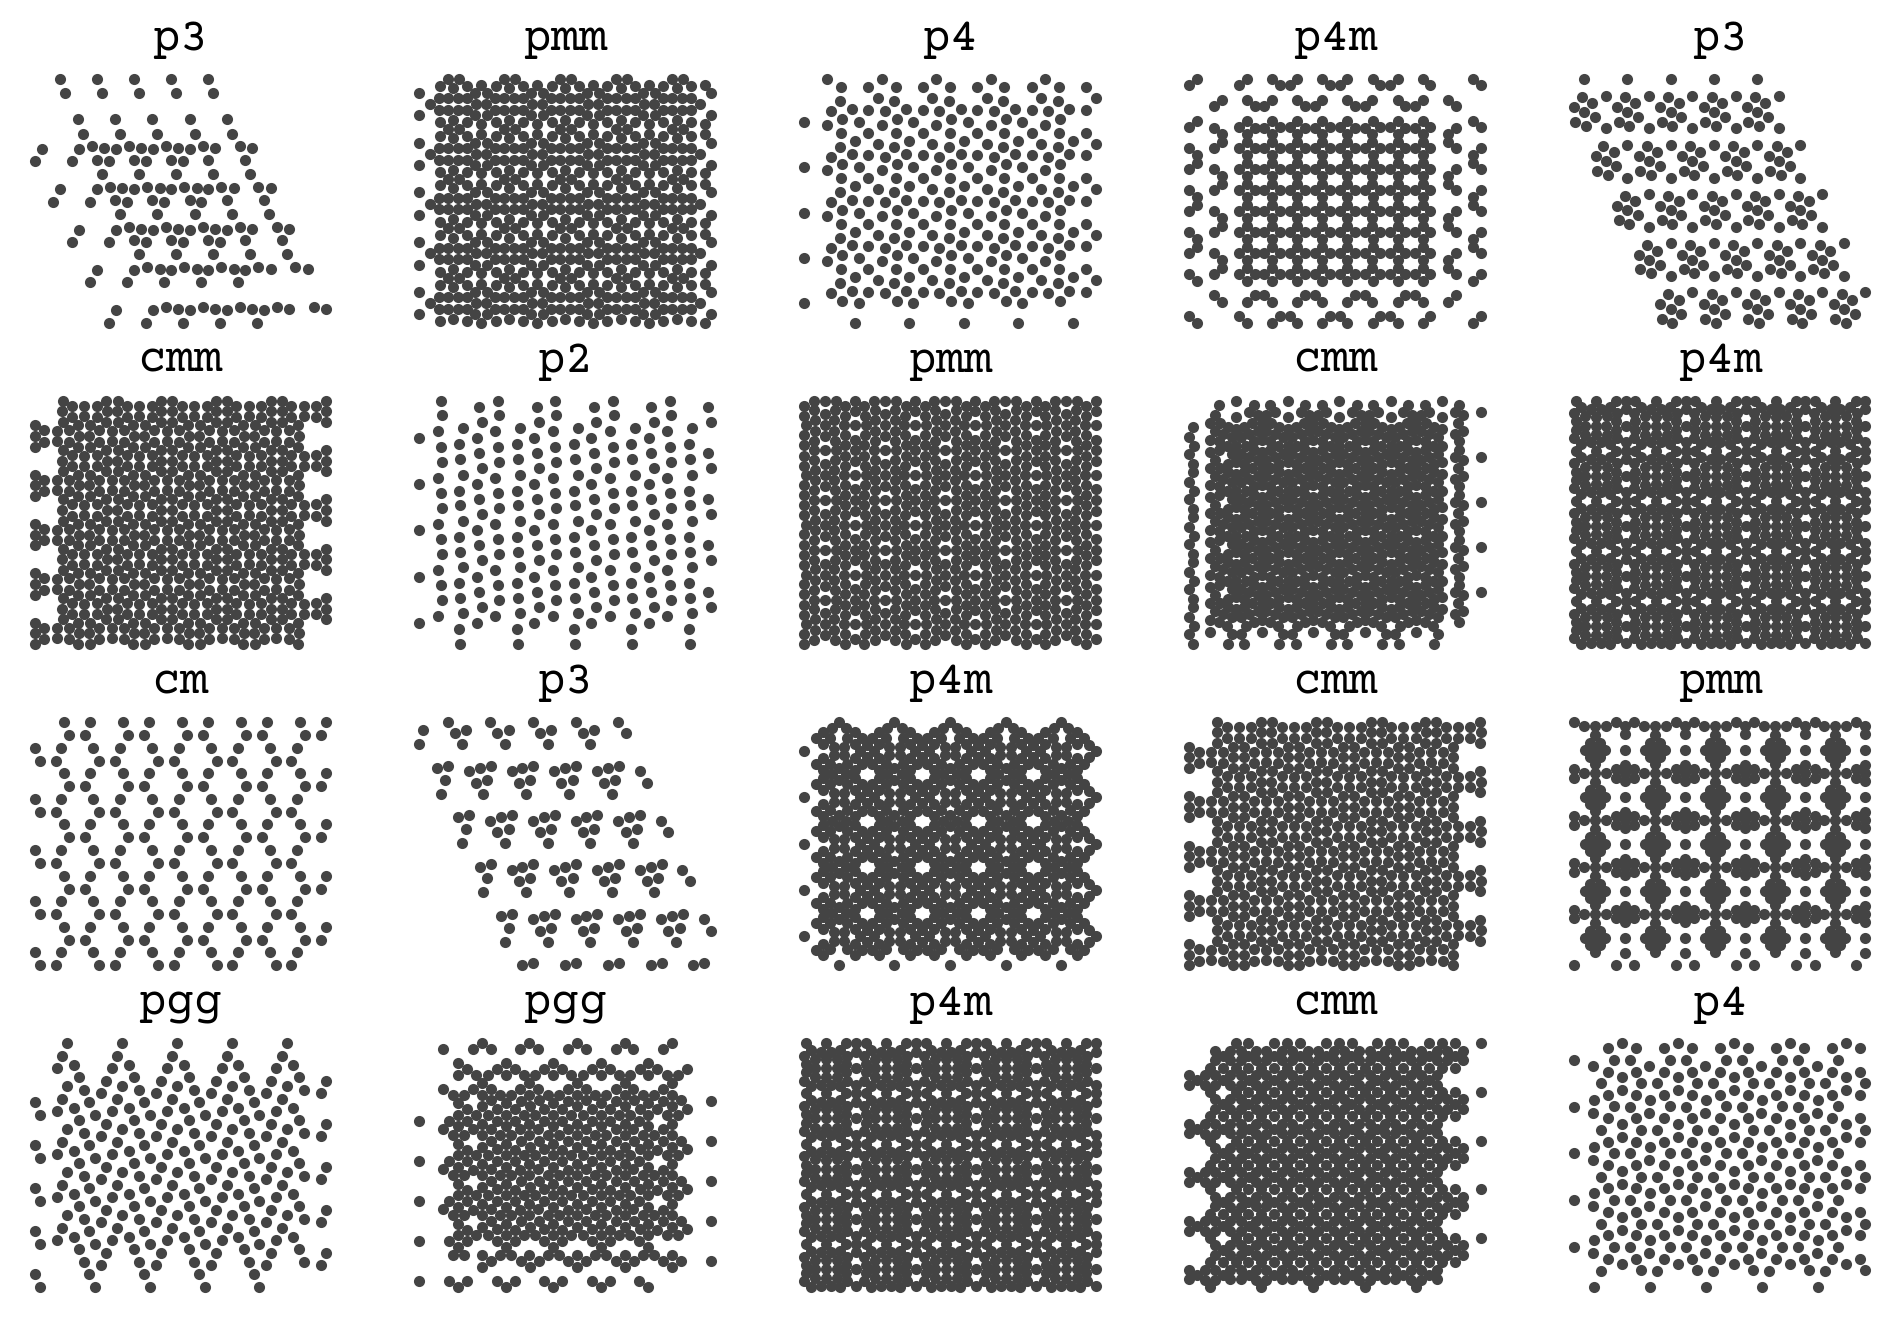

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

# get a few example and plot them
for i, (x, y) in enumerate(data):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].set_title(label_str[y.numpy()])
    axs[i].axis("off")

### Building the graphs

Como se observa en los graficos, no necesariamente todos los atomos debiesen influir sobre todos, o al menos no de la misma forma, por lo que primero se construye una funcion que calcula la distancia de todos los atomos entre si, y calcula los NN atomos que tienen menor distancia con respecto a un atomo dado, esto sin considerar la distancia que tiene un atomo consigo mismo. La salida de esta funcion es:

*   **-topk.values** : tensor shape $(\cdot ,N)$, que posee las N distancias mas pequenas con respecto al atomo de la fila i
*   **topk.indices**: tensor shape $(\cdot ,N)$, que posee los N indices correspondientes a los atomos mas cercanos al de la fila i

In [ ]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0] #number of points
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # add dim extra at 1
    qTexpand = tf.expand_dims(positions, 0)  # add dim extra at 0
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1]) #repeat M times
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype) #matriz 0 y 1
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

Se puede visualizar como define los N vecinos mas cercanos esta funcion

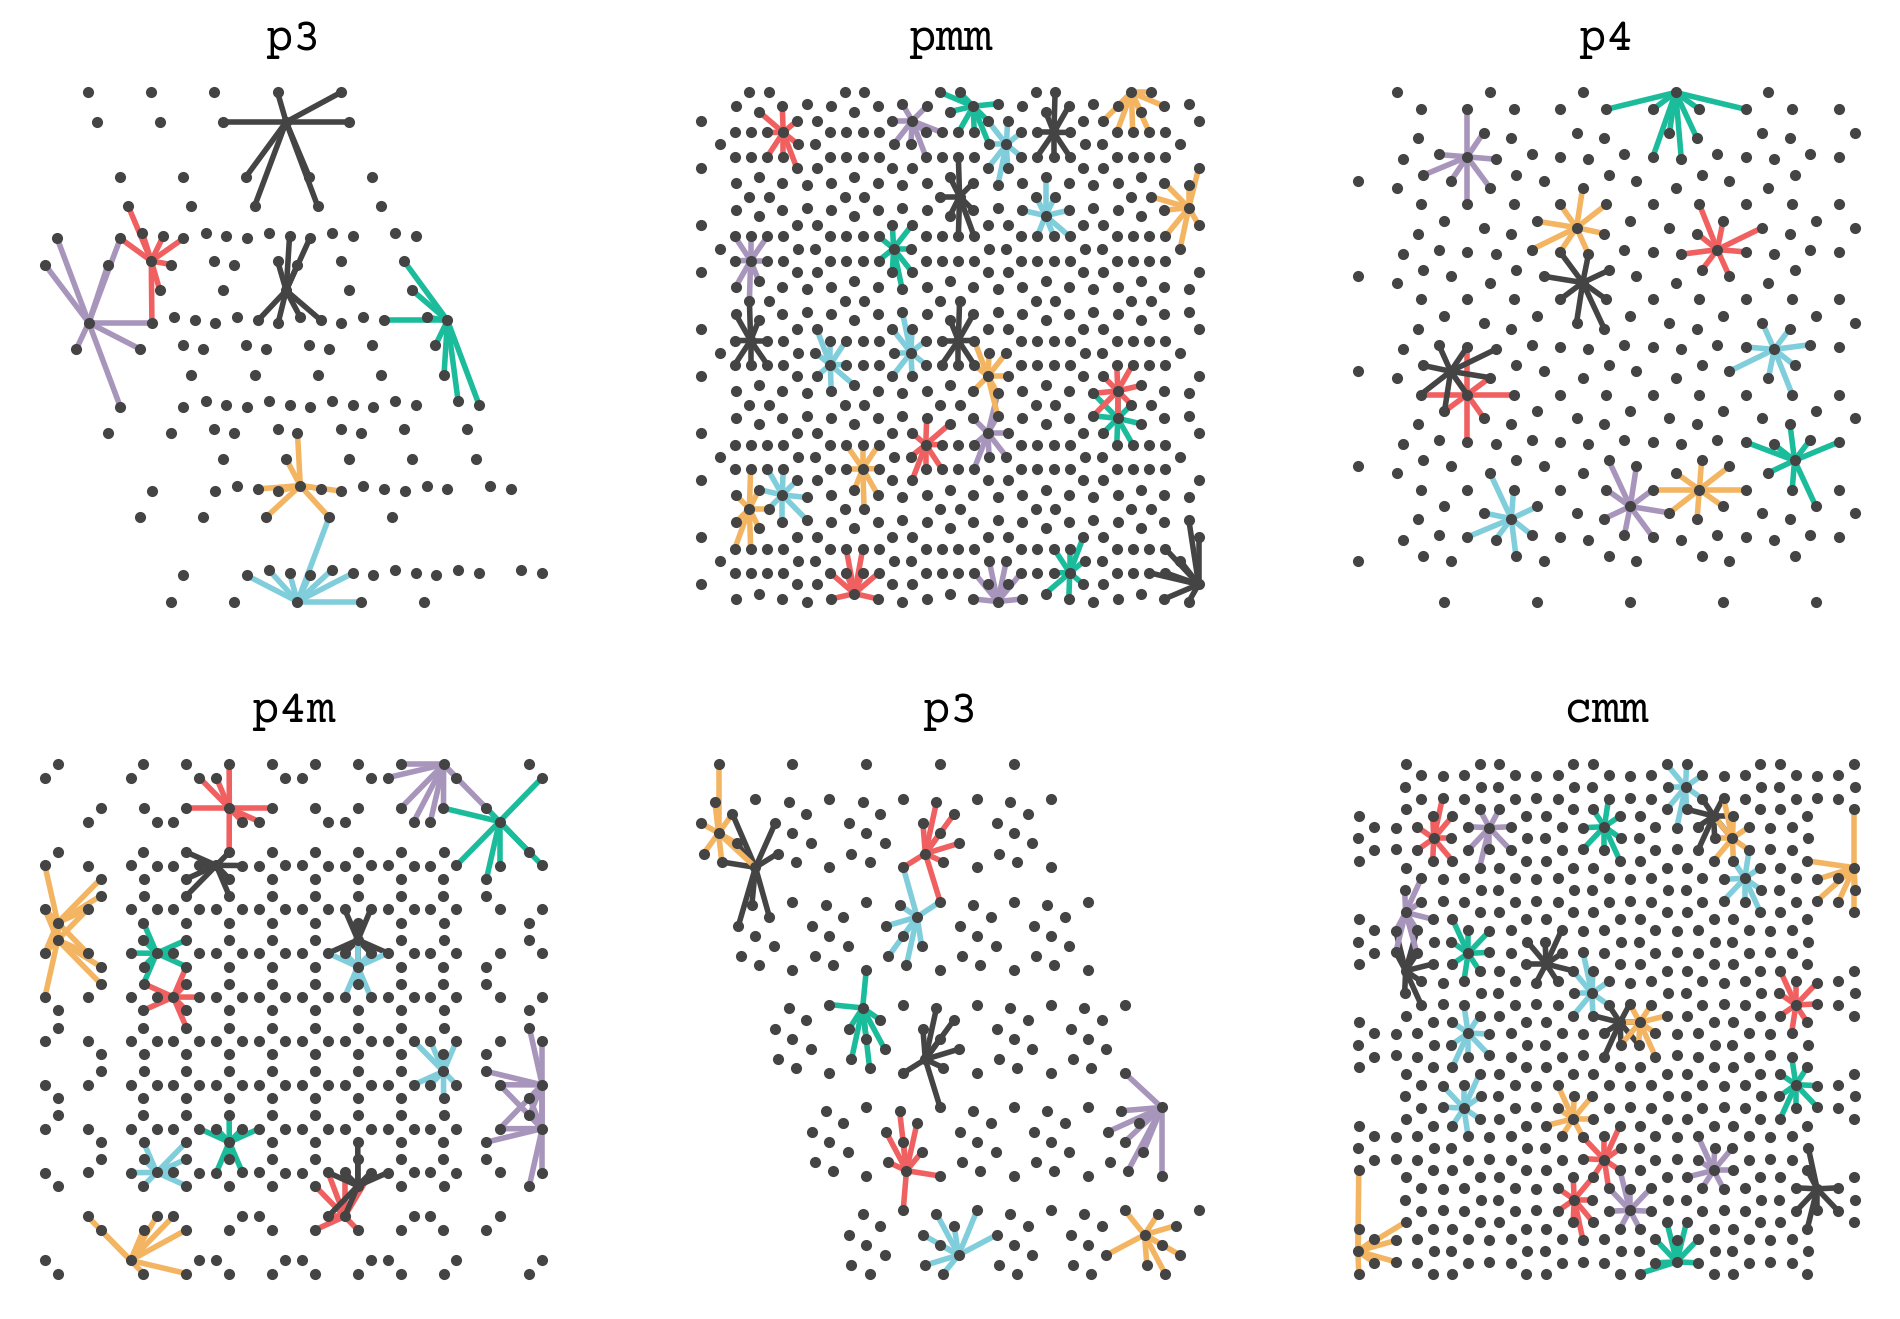

In [ ]:
from matplotlib import collections

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, (x, y) in enumerate(data):
    if i == 6:
        break
    e_f, e_i = get_edges(x, 8)
    # make things easier for plotting
    e_i = e_i.numpy()
    x = x.numpy()
    y = y.numpy()

    # make lines from origin to its neigbhors
    lines = []
    colors = []
    for j in range(0, x.shape[0], 23):
        # lines are [(xstart, ystart), (xend, yend)]
        lines.extend([[(x[j, 0], x[j, 1]), (x[k, 0], x[k, 1])] for k in e_i[j]])
        colors.extend([f"C{j}"] * len(e_i[j]))
    lc = collections.LineCollection(lines, linewidths=2, colors=colors)
    axs[i].add_collection(lc)
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].axis("off")
    axs[i].set_title(label_str[y])
plt.show()

Con esto se puede agregar esta informacion al dataset, pero es deseable mas como se explico en un comienzo anadir mas features a estas distancia que se realizan por medio de la rbf
$$
e_k = \exp\left(-\gamma \left(r - \mu_k\right)^2\right)
$$ (rbf-edge)

Donde luego cambia unicamente la matriz de distancia a un tensor de orden 3 de distancia. Especificamente al modelo se le entrega como input

- **Valores nodales**, los cuales se van a setear como 1, pero corresponden en un caso generalizado al elemento atomico
- **Tensor de distancia** $D_{ij}$ donde para cada nodo $i$ con respecto a un nodo $j$, se tiene un vector de distancia dado por la longitud de $\mu_k$ (edge features). Notar que son los $j$ vecinos mas cercanos de nodo $i$
- **Tensor de vecinos cercanos**, para nodo $i$ se muestran los $N$ vecinos cercanos, dados por sus indices

In [ ]:
MAX_DEGREE = 16
EDGE_FEATURES = 8
MAX_R = 20

# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0] #number of points
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # add dim extra at 1
    qTexpand = tf.expand_dims(positions, 0)  # add dim extra at 0
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1]) #repeat M times
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype) #matriz 0 y 1
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

gamma = 1
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (tf.ones(tf.shape(x)[0], dtype=tf.int32), edge_features, edge_i), y[None]
#ones shape of number of atoms, edge_features distance features, edge_i Max_degree closest atoms

graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)

Para agregar la nolinealidad se definen 3 capas de redes neuronales h1, h2 y h3, con una funcion de activacion shifted softplus

In [ ]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units, activation=ssp),
            tf.keras.layers.Dense(units, activation=ssp),
        ]
    )


def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )


### Implementando las GNN

In [ ]:
class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, label_dim, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(2, channels) #transform to 1 to channels
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(label_dim)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i) #choose closest atoms
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features) #calculate directions of update atoms
            e_i = tf.reduce_sum(e_k, axis=1) #compute sum over all closest atoms
            nodes += self.h3s[i](e_i) #update node feature. The edge feature are not updated
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0) #invariant operation

In [ ]:
small_schnet = SchNetModel(3, 30, len(label_str)) #3 capas 30 canales N cantidad de clases

In [ ]:
for x, y in graph_train_data:
    yhat = small_schnet(x)
    break
print(yhat.numpy())

[ 0.02203792  0.01683489 -0.00808537  0.01281161  0.0176358  -0.02412692
 -0.00332848  0.00011354 -0.00390024 -0.01931879 -0.03806086  0.01092156
 -0.03678999  0.03513249 -0.00148553 -0.0034079  -0.02223402]


La salida es correspondiente con la cantidad de clases a clasificar, luego para lograr transformar estos valores a probabilidades se usa la funcion softmax sobre los valores del output

In [ ]:
print("predicted class", tf.nn.softmax(yhat).numpy())

predicted class [0.06028244 0.0599696  0.05849361 0.05972881 0.06001765 0.05756276
 0.05877252 0.05897516 0.05873892 0.0578402  0.05676625 0.05961603
 0.05683844 0.061077   0.05888093 0.05876786 0.05767183]


### Entrenamiento

Queda unicamente entrenar el modelo!, como es un problema de clasificacion se usara la funcion de perdida de entropia cruzada de valores logits (es decir no son probabilidades). Como las categorias a clasificar son enteros, se ajusta con la opcion "sparse"

In [ ]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["sparse_categorical_accuracy"],
)
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=20)

Epoch 1/20
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 167s 101ms/step - loss: 2.7614 - sparse_categorical_accuracy: 0.1150 - val_loss: 2.6423 - val_sparse_categorical_accuracy: 0.1386
Epoch 2/20
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 198s 98ms/step - loss: 2.6359 - sparse_categorical_accuracy: 0.1203 - val_loss: 2.6014 - val_sparse_categorical_accuracy: 0.0693
Epoch 3/20
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 207s 101ms/step - loss: 2.6036 - sparse_categorical_accuracy: 0.1126 - val_loss: 2.5710 - val_sparse_categorical_accuracy: 0.0693
Epoch 4/20
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 201s 101ms/step - loss: 2.5864 - sparse_categorical_accuracy: 0.1195 - val_loss: 2.5598 - val_sparse_categorical_accuracy: 0.0792
Epoch 5/20
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - loss: 2.5792 - sparse_categorical_accuracy: 0.1207 - val_loss: 2.5561 - val_sparse_categorical_accuracy: 0.0891
Epoch 6/20
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 168s 108ms/step - loss: 2.5751 - sparse_categorical_accuracy: 0.1248 - val_loss: 2.5550 - val_spars

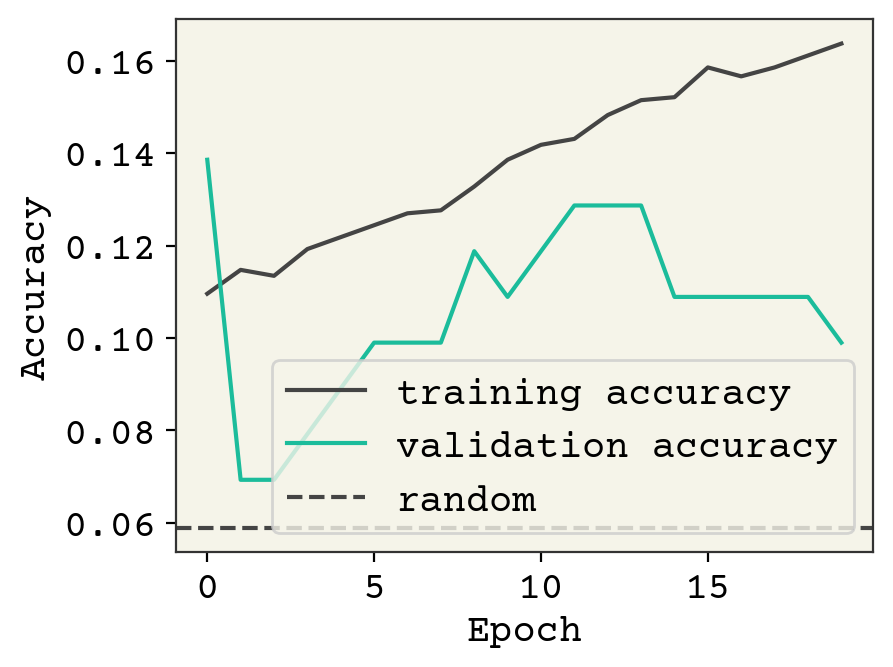

In [ ]:
plt.plot(result.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(result.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.axhline(y=1 / 17, linestyle="--", label="random")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

El resultado a priori no es tan bueno, pero se puede seguir mejorando en base a agregar mas capas, aumentar las node features o los edge features, como lo realiza el paper de SchNet ([K. T. Schütt, 2018](https://doi.org/10.1063/1.5019779)), con 3 capas, 64 nodes features, 300 edge features, y probablemente muchas mas epocas que las mostradas

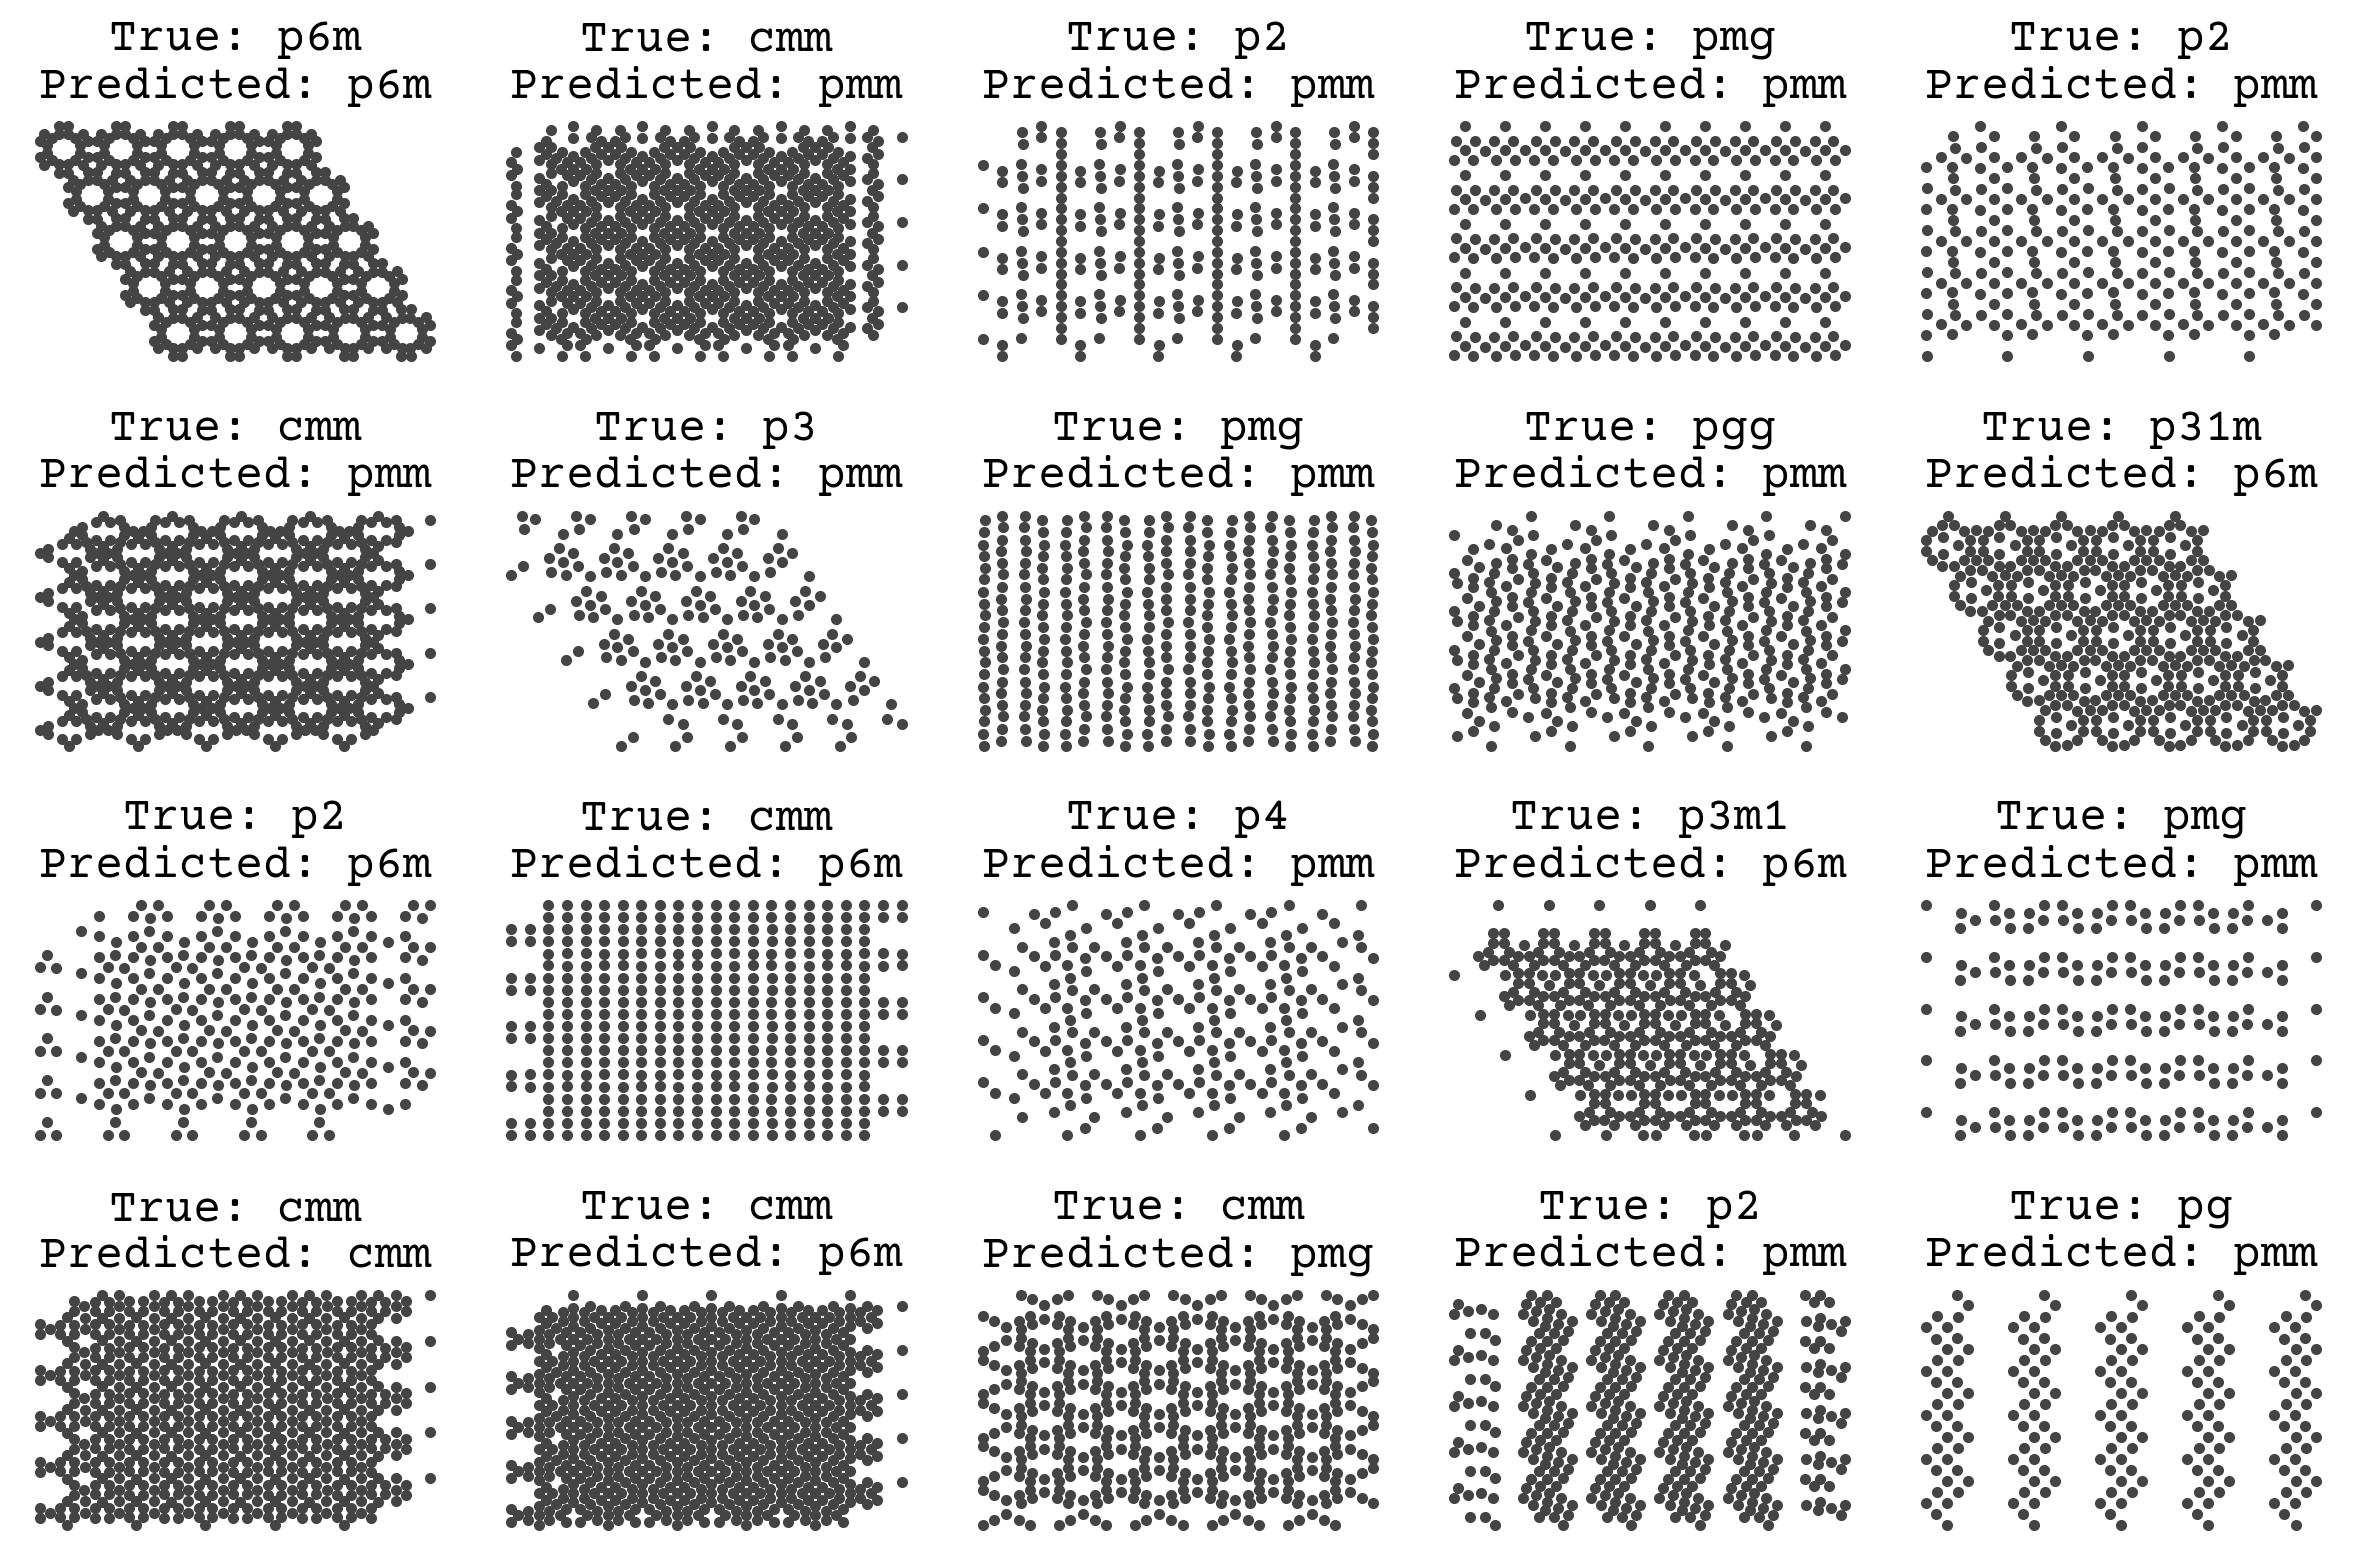

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

for i, ((x, y), (gx, _)) in enumerate(zip(test_data, graph_test_data)):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    yhat = small_schnet(gx)
    yhat_i = tf.math.argmax(tf.nn.softmax(yhat)).numpy()
    axs[i].set_title(f"True: {label_str[y.numpy()]}\nPredicted: {label_str[yhat_i]}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()